In [1]:
# Import important libraries 
import tensorflow as tf
import pandas as pd
from IPython.display import YouTubeVideo
import os
import pickle
import random

In [2]:
# Constants
folder_path = '../2/frame/train'                                      # Folder path where Youtube-8M dataset will be saved.
records_path = folder_path
shard_no = 1                                                       # The shard no of dataset to be downloaded. (Total 100 Shards)
server_location = 'us'                                             # Specifies the geographical region or server mirror to optimize download speed. Choose from 'us' for United States, 'eu' for Europe, or 'asia' for Asia.
# Location to saved commercial and non_commercial features
commercial_RgbFeatures_path      =  'commercial_Rgb.pkl'
commercial_AudioFeatures_path    =  'commercial_Audio.pkl'
nonCommercial_RgbFeatures_path   =  'non_Commercial_Rgb.pkl'
nonCommercial_AudioFeatures_path =  'non_Commercial_Audio.pkl'

### If you have already downloaded the dataset, then you can skip the next 2 cells where a new shard of dataset is being downloaded

In [3]:
def create_folder(folder_path):
    """
    Creates a folder/directory at the specified path if it doesn't already exist.

    Parameters:
    - folder_path (str): The path where the new folder will be created.

    Returns:
    - return True/False, whether the folder is created successfully or not.
    """
    if not os.path.exists(folder_path):
        try:
            os.makedirs(folder_path)
            print(f"Directory '{folder_path}' created successfully.")
            return True
        except OSError as e:
            print(f"Error: Creating directory '{folder_path}' failed. {e}")
            return False
    else:
        print(f"Directory '{folder_path}' already exists.")
        return False
     
def download_dataset(folder_path, shard_no, server_location):
    """
    Downloads first shard(1/100th) of Youtube-8M dataset inside folder_path location.

    Parameters:
    - folder_path (str)    : The path where the datset will be downloaded.
    - server_location (str): Specifies the geographical region or server mirror to optimize download speed.
      Choose from 'us' for United States, 'eu' for Europe, or 'asia' for Asia.
    """
    if not create_folder(folder_path):
        return
    currentDir = os.getcwd()
    %cd {folder_path}
    !curl data.yt8m.org/download.py | shard={shard_no},100 partition=2/frame/train mirror={server_location} python
    %cd {currentDir}

In [4]:
download_dataset(folder_path, shard_no, server_location)

Directory '../2/frame/train' already exists.


In [ ]:
def load_features(filename):
    """
    Load data from a pickled file if it exists, otherwise initialize an empty list.

    Parameters:
    - filename (str): The path to the pickled file.
    Returns:
    - list: The loaded data from the file, or an empty list if the file doesn't exist.
    """
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            print(f'Loaded {filename} successfully.')
    else:
        print(f'{filename} not found. Initializing as empty list.')
        data = []
    return data

In [ ]:
# Load commercial data features
commercial_Rgb = load_features(commercial_RgbFeatures_path)
commercial_Audio = load_features(commercial_AudioFeatures_path)
# Load non-commercial data features
non_Commercial_Rgb = load_features(nonCommercial_RgbFeatures_path)
non_Commercial_Audio = load_features(nonCommercial_AudioFeatures_path)

In [8]:
# Verifying the loading of features
print(f'Number of TV Advertisement RGB feature lists loaded: {len(commercial_Rgb)}')
print(f'Number of TV Advertisement audio feature lists loaded: {len(commercial_Audio)}')
# Verifying the loading of features
print(f'Number of Non-TV RGB feature lists loaded: {len(non_Commercial_Rgb)}')
print(f'Number of Non-Tv audio feature lists loaded: {len(non_Commercial_Audio)}')

Number of TV Advertisement RGB feature lists loaded: 0
Number of TV Advertisement audio feature lists loaded: 0
Number of Non-TV RGB feature lists loaded: 0
Number of Non-Tv audio feature lists loaded: 0


In [9]:
filtered_vid_ids = []           # This array stores the video IDs of Television Advertisement label extracted from the TFRecord file.
filtered_labels = []            # This array stores the label_ids associated with Television Advertisment label_id(315). The label ids are mapped to label names through vocabulary.csv which is discussed later.
filtered_rgb = []               # This array stores the RGB features of Television Advertisement label.
filtered_audio = []             # This array stores the audio features of Television Advertisement label.
non_filtered_vid_ids = []       # This array stores the video IDs without the Television Advertisement label extracted from the TFRecord file.
non_filtered_labels = []        # This array stores the label_ids associated without Television Advertisment label_id(315). The label ids are mapped to label names through vocabulary.csv which is discussed later.
non_filtered_rgb = []           # This array stores the RGB features without the Television Advertisement label.
non_filtered_audio = []         # This array stores the audio features without the Television Advertisement label.

In [10]:
def decode_quantized_features(features):
    """
    Decodes the quantized RGB or audio features from a TFRecord.

    Parameters:
    - features: A TensorFlow Feature object containing quantized data (bytes).

    Returns:
    - Decoded features as TensorFlow tensors of type tf.uint8.
    """
    return tf.io.decode_raw(features, tf.uint8)

In [11]:
# List all .tfrecord files in the directory
tfrecord_files = [os.path.join(records_path, f) for f in os.listdir(records_path) if f.endswith('.tfrecord')]

# The specific labels for the non-filtered lists
specific_labels = {12, 329, 282, 52, 67, 92, 118, 653}

In [12]:
# Iterate over each .tfrecord file
counter = 0
for tfrecord_file in tfrecord_files:
    print(f'counter {counter}')
    counter+=1
    print(f'Processing file: {tfrecord_file}')
    # Iterate over each tfrecord in the TFRecord file
    try:
        for record in tf.compat.v1.python_io.tf_record_iterator(tfrecord_file):
            try:
                # Parse the SequenceExample from the binary record data
                seq_example = tf.train.SequenceExample.FromString(record)

                # Extract the video_id and labels
                vid_id = seq_example.context.feature['id'].bytes_list.value[0].decode('UTF-8')
                labels_list = seq_example.context.feature['labels'].int64_list.value

                # Check if the label ID 315 is in the labels list (label id 315 corresponds to Television Advertisement)
                if 315 in labels_list:
                    # Append video ID and labels to the filtered lists
                    filtered_vid_ids.append(vid_id)
                    filtered_labels.append(labels_list)

                    # Lists to store frame-level and audio-level features
                    rgb_features = []
                    audio_features = []

                    # Iterate over each frame-level feature pair (RGB and audio) in the SequenceExample
                    for rgb_feature, audio_feature in zip(seq_example.feature_lists.feature_list['rgb'].feature,
                                                          seq_example.feature_lists.feature_list['audio'].feature):
                        
                        # Decode the quantized RGB features and audio features
                        decoded_rgb = decode_quantized_features(rgb_feature.bytes_list.value[0])
                        decoded_audio = decode_quantized_features(audio_feature.bytes_list.value[0])

                        rgb_features.append(decoded_rgb)
                        audio_features.append(decoded_audio)

                    # Append frame-level lists to the main filtered lists
                    filtered_rgb.append(rgb_features)
                    filtered_audio.append(audio_features)
                else:
                    # Check if the labels list contains any of the specific labels
                    if any(label in specific_labels for label in labels_list):
                        # Append video ID and labels to the non-filtered lists
                        non_filtered_vid_ids.append(vid_id)
                        non_filtered_labels.append(labels_list)

                        # Lists to store frame-level and audio-level features
                        rgb_features = []
                        audio_features = []

                        # Iterate over each frame-level feature pair (RGB and audio) in the SequenceExample
                        for rgb_feature, audio_feature in zip(seq_example.feature_lists.feature_list['rgb'].feature,
                                                              seq_example.feature_lists.feature_list['audio'].feature):
                            
                            # Decode the quantized RGB features and audio features
                            decoded_rgb = decode_quantized_features(rgb_feature.bytes_list.value[0])
                            decoded_audio = decode_quantized_features(audio_feature.bytes_list.value[0])

                            rgb_features.append(decoded_rgb)
                            audio_features.append(decoded_audio)

                        # Append frame-level lists to the main non-filtered lists
                        non_filtered_rgb.append(rgb_features)
                        non_filtered_audio.append(audio_features)

            except tf.errors.DataLossError as e:
                print(f'Skipping corrupted record in file {tfrecord_file}: {e}')
    except tf.errors.DataLossError as e:
        print(f'Skipping entire file due to corruption: {tfrecord_file}: {e}')

# At this point, the following lists contain the relevant data:
# filtered_vid_ids, filtered_labels, filtered_rgb, and filtered_audio contain data for videos with the label "Television advertisement".
# non_filtered_vid_ids, non_filtered_labels, non_filtered_rgb, and non_filtered_audio contain data for videos with the specified labels.

counter 0
Processing file: 2/frame/train/train1745.tfrecord
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
counter 1
Processing file: 2/frame/train/train3702.tfrecord
counter 2
Processing file: 2/frame/train/train3220.tfrecord
counter 3
Processing file: 2/frame/train/train0352.tfrecord
counter 4
Processing file: 2/frame/train/train2950.tfrecord
counter 5
Processing file: 2/frame/train/train1646.tfrecord
counter 6
Processing file: 2/frame/train/train3551.tfrecord
counter 7
Processing file: 2/frame/train/train3519.tfrecord
counter 8
Processing file: 2/frame/train/train0667.tfrecord
counter 9
Processing file: 2/frame/train/train0477.tfrecord
counter 10
Processing file: 2/frame/train/train3622.tfrecord
counter 11
Processing file: 2/frame/train/train0503.tfrecord
counter 12
Processing file: 2/frame/train/train2722.tfrecord
counter 13
Processing file: 2/frame/train/train0434.tfrecord
counter 14
Processing file: 2/frame/train/train3012.tfrecord
counter 15

In [13]:
print('Number of videos in the new commercial dataset: ',len(filtered_vid_ids))
print ('Number of labels in the new commercial dataset: ', len (filtered_labels))
print('Length of visual features: ', len(filtered_rgb))
print('Length of audio features', len(filtered_audio))
print('Picking a youtube video id:',filtered_vid_ids[5])

Number of videos in the new commercial dataset:  61
Number of labels in the new commercial dataset:  61
Length of visual features:  61
Length of audio features 61
Picking a youtube video id: cpVK


In [14]:
print('Number of videos in the new commercial dataset: ',len(non_filtered_vid_ids))
print ('Number of labels in the new commercial dataset: ', len (non_filtered_labels))
print('Length of visual features: ', len(non_filtered_rgb))
print('Length of audio features', len(non_filtered_audio))
print('Picking a youtube video id:',non_filtered_vid_ids[5])

Number of videos in the new commercial dataset:  2469
Number of labels in the new commercial dataset:  2469
Length of visual features:  2469
Length of audio features 2469
Picking a youtube video id: 8pCj


In [15]:
print(filtered_vid_ids)

['IiCj', 'l5Cj', 'i2Z6', 'iPZ6', 'bzfQ', 'cpVK', 'XGVK', 'nCAI', 'VxAI', 'ir5r', 'yo5r', 'Ju4V', 'hx4V', 'WVkV', 'prhR', 'jehR', 'cT6A', 'qp6A', 'ODih', 'F7R4', '5aWK', 'jHeA', 'UJeA', 'gFeA', 'kmUY', 'JAUY', '59bX', 'vCbX', 'tJny', 'Ofdw', 'qL6l', '7hOp', 'EoOp', 'xmrH', 'e2rH', '1oHA', 'JAHA', '5N8D', 'vCbF', 'MtbF', 'RbbF', 'qMbF', 'UrbF', 'p8Tb', 'ZmTb', 'rQTb', 'u0Tb', 'Lfkr', '62kr', 'ZKkr', 'wm45', 'g245', 'F1Ee', 'J0IU', 'KyIU', 'BLeC', 'GKpX', 'Y0pX', 'JZpX', '1bI0', '3fI1']


In [16]:
print(non_filtered_vid_ids)

['4iCj', 'UQCj', 'mWCj', 'OvCj', '43Cj', '8pCj', '9OCj', 'z6Cj', 'qqCj', '9CCj', 'nOCj', '3SCj', 'MCCj', 'SoCj', 'iZCj', 'DECj', 'ddCj', 'RZCj', 'N1Cj', 'z9Cj', 'AoCj', 'RkCj', 'hDCj', 'VbCj', 'RUCj', 'jpCj', 'OgCj', '8KCj', '4GCj', 'NKCj', '4aCj', 'G7Cj', '0lCj', 'sSCj', 'qtCj', 'nTCj', 'xtCj', 'i2Cj', 'HnCj', '6hCj', 'W7Cj', 'kICj', 'uhCj', 'ODCj', 'TxCj', 'pUCj', 'DgCj', 'ONCj', 'YnCj', 'BnCj', 'h2Cj', 'noCj', 'L1Cj', 'OYCj', 'PTCj', 'jMCj', 'EeCj', 'Fh7S', 'iU7S', 'my7S', 'XC7S', 'X07S', 'Ah7S', 'cq7S', 'jJ7S', 'KG7S', 'ks7S', '2F7S', 'Ku7S', 'kh7S', 'nu7S', '7z7S', '3I7S', 'B47S', 'wn7S', 'Do7S', 'eZ7S', 'LB7S', 'nW7S', 'Sk7S', 'NK7S', 'Sm7S', 'J17S', 'eO7S', '7Q7S', 'oy7S', 'eB7S', 'rX7S', '7u7S', 'tY7S', 'cB7S', 'GD7S', 'yj7S', 'Id7S', 'wA7S', 'aI7S', 'Gz7S', 'BJ7S', 'kA7S', 'vQ7S', 'yT7S', 'zJ7S', 'Ay7S', '0F7S', '5J7S', 'rh7S', 'dZ7S', 'oN7S', '04Z6', 'hjZ6', 'p5Z6', 'CQZ6', '1XZ6', '3zZ6', 'CHZ6', 'erZ6', 'QDZ6', 'I2Z6', 'YvZ6', 'JVZ6', 'zsZ6', 'JMZ6', 'TqZ6', 'SlZ6', 'BQZ6',

- The video id wZ6U maps to wyHcL23Jvzs.

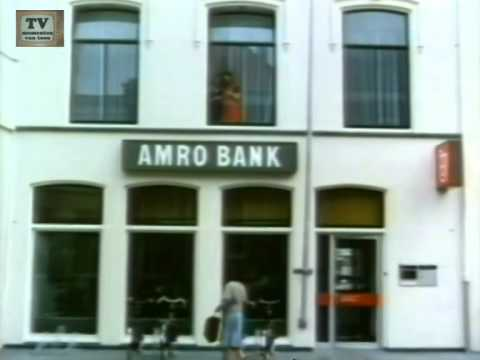

In [17]:
YouTubeVideo('DwnHaKYXbo0')

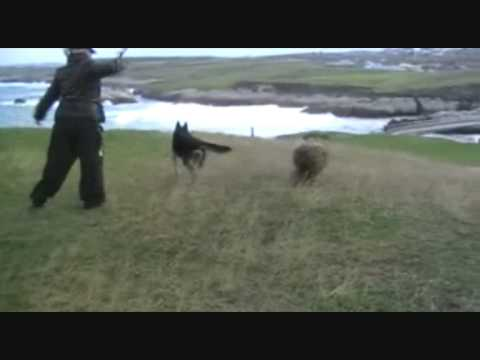

In [18]:
YouTubeVideo('XoxB1IPkG5Q')

In [19]:
# Randomly select 400 consistent pairs of RGB and audio features
if len(non_filtered_rgb) >= 400:
    selected_indices = random.sample(range(len(non_filtered_rgb)), 400)
    print(selected_indices)
    selected_rgb = [non_filtered_rgb[i] for i in selected_indices]
    selected_audio = [non_filtered_audio[i] for i in selected_indices]
else:
    print("Not enough non-filtered data to select 400 samples")

[1172, 1700, 2106, 1351, 1530, 2286, 1726, 2405, 2184, 1353, 2009, 489, 920, 439, 1074, 1394, 2024, 2117, 1303, 1061, 1223, 2153, 475, 1405, 1317, 317, 96, 2162, 1703, 1820, 2105, 1871, 2234, 803, 639, 2253, 1827, 1137, 864, 812, 1810, 508, 1254, 520, 443, 1968, 490, 1136, 2252, 1283, 2218, 1039, 2091, 1105, 750, 1431, 1123, 213, 961, 1165, 1591, 642, 2163, 2161, 1698, 2145, 2007, 614, 448, 2063, 427, 1296, 1941, 1889, 488, 1289, 532, 839, 127, 134, 1026, 246, 979, 1997, 1769, 702, 2368, 1342, 2027, 1106, 1503, 1772, 420, 659, 1436, 421, 1237, 770, 1770, 1650, 908, 1258, 1705, 1647, 1811, 164, 704, 2334, 1055, 482, 163, 2426, 140, 1086, 2458, 743, 1621, 551, 937, 1645, 951, 2226, 672, 105, 962, 1156, 1637, 1927, 503, 1893, 507, 39, 2202, 2308, 1018, 1574, 73, 1329, 2090, 1195, 69, 79, 869, 2374, 1988, 813, 1391, 2101, 1464, 2277, 1718, 1013, 1585, 102, 202, 2169, 1564, 1157, 1201, 2261, 337, 2305, 924, 1066, 1239, 2367, 1895, 500, 2297, 1474, 684, 2443, 1141, 1383, 1307, 1785, 178, 165

In [20]:
# Add the current shards non-commercial features to previously processed shards non-commercial features
non_Commercial_Rgb+=(selected_rgb)
non_Commercial_Audio+=(selected_audio)

In [21]:
# Add the current shards commercial features to previously processed shards commercial features
commercial_Rgb+=filtered_rgb
commercial_Audio+=filtered_audio

In [22]:
print(f'Number of TV Advertisement RGB feature lists loaded: {len(commercial_Rgb)}')
print(f'Number of TV Advertisement audio feature lists loaded: {len(commercial_Audio)}')
print(f'Number of Non-TV RGB feature lists loaded: {len(non_Commercial_Rgb)}')
print(f'Number of Non-Tv audio feature lists loaded: {len(non_Commercial_Audio)}')

Number of TV Advertisement RGB feature lists loaded: 61
Number of TV Advertisement audio feature lists loaded: 61
Number of Non-TV RGB feature lists loaded: 500
Number of Non-Tv audio feature lists loaded: 500


In [33]:
# The filtered audio-visual features of Television Advertisement is saved 
with open('commercial_Rgb.pkl', 'wb') as f:
    pickle.dump(commercial_Rgb, f)

with open('commercial_Audio.pkl', 'wb') as f:
    pickle.dump(commercial_Audio, f)

print('Commercial data features saved successfully.')

Commercial data features saved successfully.


In [34]:
print(len(non_Commercial_Rgb))
print(len(non_Commercial_Audio))

1000
1000


In [35]:
# The Non-Commercial audio-visual features of Television Advertisement is saved 
with open('non_Commercial_Rgb.pkl', 'wb') as f:
    pickle.dump(non_Commercial_Rgb, f)

with open('non_Commercial_Audio.pkl', 'wb') as f:
    pickle.dump(non_Commercial_Audio, f)

print('Non-Commercial data features saved successfully.')

Non-Commercial data features saved successfully.
